# XGBoost

### Sina Stumpp (Matrikelnummer: 590868)

In [303]:
# Importieren der notwendigen Bibliotheken
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from xgboost import plot_importance, plot_tree
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import re
from matplotlib.ticker import FuncFormatter

## Daten einlesen 
#### (Übernahme aus Kapitel Preprocessing)

In [304]:
# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

### Features 

In [305]:
# numerische Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

## Split
#### (Übernahme aus Kapitel Preprocessing)

In [306]:
# Datensatz nach Datum sortieren
data = data.sort_values('Date')

# Tage, an denen Stores geschlossen sind oder nichts verkauft wurde ausschließen
data = data[data ['Open']!=0]
data = data[data ['Sales']>0]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Open'], axis=1) 
y = data['Sales']


# Berechnung der Anzahl der Testdaten (20 % des Datensatzes)
test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

## Metrik
#### (Übernahme aus Kapitel Preprocessing)

In [307]:
# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

In [308]:
# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

## Kreuzvalidierung (TimeSeries)
#### (Übernahme aus Kapitel Preprocessing)

In [309]:
# Zeitreihen-Kreuzvalidierung einrichten
tscv = TimeSeriesSplit(n_splits=5)

## Pre-processing
#### (Übernahme aus Kapitel Preprocessing)

In [310]:
# Erstellung Preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung 
        ('enc', 'passthrough', already_encoded_features),  # Durchschleusung für Features ohne weitere Transformation
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Features encodieren
    ])

## XGBoost

XGBoost (Extreme Gradient Boosting) ist ein leistungsstarker maschineller Lernalgorithmus, der auf dem Prinzip des Gradient Boosting basiert. Er kombiniert mehrere schwache Modelle, in der Regel Entscheidungsbäume, um ein starkes Modell zu erzeugen. XGBoost zeichnet sich durch seine Effizienz, Skalierbarkeit und Flexibilität aus, da es verschiedene Regularisierungsmethoden unterstützt, um Überanpassung zu verhindern. Für die Zeitreihenvorhersage der Verkaufszahlen von Rossmann ist XGBoost geeignet, da es gut mit nichtlinearen und komplexen Beziehungen umgehen kann. Außerdem kann es fehlende Daten bewältigen, unterschiedliche Zeitabstände verarbeiten und historische Trends sowie saisonale Muster effektiv modellieren, was für Verkaufsprognosen entscheidend ist.

Im folgenden Code wird eine Pipeline erstellt, die aus der Vorverarbeitung der Daten und einem XGBoost-Modell besteht. Das Modell nutzt dabei die Standardeinstellungen der Hyperparameter. Zusätzlich wurde random_state = 42 gesetzt, um sicherzustellen, dass die Ergebnisse vergleich- und reproduzierbar sind, da dieser Wert die Zufallsinitialisierung im Modell fixiert. 

Quelle: Scikit-learn developers(a), XGBoost developers(a), XGBoost developers(b)

In [311]:
# Definition XGBoost-Pipeline
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(random_state = 42))
])

Die zuvor definierte Pipeline wird anschließend mit dem Befehl pipeline_xgb.fit(X_train, y_train) auf die Trainingsdaten angewendet. Das Modell wird dabei mit den Date  X_train und den Zielwerten y_train trainiert. Die Pipeline führt zuerst die Vorverarbeitung der Daten durch und passt dann das XGBoost-Modell an.

In [312]:
# Training des Modells
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortm...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

Im nächsten Schritt wird die Kreuzvalidierung mittels cross_val_score durchgeführt, um die Performance der Pipeline auf den Trainingsdaten zu bewerten. Hierbei wird die Pipeline mehrmals mit unterschiedlichen Trainings- und Validierungsdatensätzen ausgeführt, die durch den zeitbasierten Cross-Validator tscv bestimmt werden. Dabei wird der benutzerdefinierte RMSPE-Scorer verwendet, um die Modellleistung zu bewerten, und durch den Parameter verbose=True werden Details über den Fortschritt der Berechnungen angezeigt. 

Quelle: Scikit-learn developers(b)

In [313]:
# Kreuzvalidierung 
cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

Das Ergebnis der Kreuzvalidierung wird als Array von RMSPE-Werten (Root Mean Squared Percentage Error) für mehrere Faltungsdurchläufe ausgegeben. Die Werte repräsentieren die Modellperformance in den jeweiligen Folds der Cross-Validation. Die Werte der verschiedenen Folds zeigen, dass z.T. große Unterschiede innerhalb der Folds bestehen bestehen.

In [314]:
# Ergebnisse der einzelnen Folds
cv_scores

array([-0.41794339, -0.33914783, -0.35268537, -0.31360045, -0.45600596])

Der Mittelwert der Fehler über alle Folds gebildet liegt bei mean_rmspe = -0.3758766016105483. Ein niedrigerer Wert deutet auf eine bessere Vorhersageleistung hin. In diesem Fall zeigt das Ergebnis, dass das Modell einen durchschnittlichen prozentualen Fehler von etwa 37,6 % bei den Vorhersagen hat. 

In [315]:
# durchschnittliches Ergebnis
mean_rmspe = np.mean(cv_scores)
mean_rmspe

-0.3758766016105483

Das Ergebnis zeigt einen RMSPE von 0.3383, was bedeutet, dass der durchschnittliche prozentuale Fehler der Vorhersagen bei etwa 33.8% liegt. Ohne Optimierung ist der Fehler damit verhältnismäßig hoch und deutet darauf hin die Hyperparameter entsprechend anzupassen. 

In [316]:
# Testergebnis
y_pred = pipeline_xgb.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.3383025676439931

## Feature Importance

Zur Untersuchung der Wichtigkeit der einzelnen Merkmale (Features) des Modells werden die Feature-Wichtigkeiten (Importances) aus dem trainierten XGBoost-Modell extrahiert und in einem DataFrame mit den zugehörigen Feature-Namen zusammengeführt. Dieser DataFrame wird nach der Wichtigkeit der Features sortiert, um anzuzeigen, welche Merkmale den größten Einfluss auf das Modell haben. 

Quelle: Brownlee(2020)

In [317]:
# Preprocessor
preprocessor_xgb = pipeline_xgb.named_steps['preprocessor']

# Transformiere die Trainingsdaten, um die Feature-Namen nach der Transformation zu erhalten
X_train_transformed = preprocessor_xgb.fit_transform(X_train)

# Feature Namen extrahieren
feature_names = X_train.columns
if hasattr(preprocessor_xgb, 'get_feature_names_out'):
    feature_names = preprocessor_xgb.get_feature_names_out()

# Feature Importances abrufen
importances = pipeline_xgb.named_steps['model'].feature_importances_

# Features und ihre Wichtigkeit zusammenstellen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sortieren nach Wichtigkeit
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Ausgabe der Feature Importance
feature_importance_df

,Feature,Importance
18,cat__StoreType_b,0.011975
410,cat__Store_383,0.010763
815,cat__Store_788,0.010509
725,cat__Store_698,0.010422
844,cat__Store_817,0.010306
...,...,...
605,cat__Store_578,0.000000
606,cat__Store_579,0.000000
209,cat__Store_182,0.000000
608,cat__Store_581,0.000000


Die Ausgabe zeigt, dass 337 Features einen aktiven Einfluss auf die Vorhersagen des Modells nehmen. 

In [318]:
# Features die Einfluss nehmen
feature_importance_df[feature_importance_df['Importance'] > 0]

,Feature,Importance
18,cat__StoreType_b,0.011975
410,cat__Store_383,0.010763
815,cat__Store_788,0.010509
725,cat__Store_698,0.010422
844,cat__Store_817,0.010306
...,...,...
19,cat__StoreType_c,0.000052
272,cat__Store_245,0.000031
12,cat__DayOfWeek_3,0.000025
13,cat__DayOfWeek_4,0.000021


Die restlichen Features nehmen mit einer Importance von 0 keinen Einfluss.

In [319]:
# irrelevante Features
feature_importance_df[feature_importance_df['Importance'] == 0]

,Feature,Importance
885,cat__Store_858,0.0
884,cat__Store_857,0.0
865,cat__Store_838,0.0
866,cat__Store_839,0.0
867,cat__Store_840,0.0
...,...,...
605,cat__Store_578,0.0
606,cat__Store_579,0.0
209,cat__Store_182,0.0
608,cat__Store_581,0.0


Das kategorische Feature StoreType_b hat mit 0.011975 die höchste Importance. Darauf folgen verschiedene Store-Features. Mittleren Einfluss haben weitere Store-Features, sowie Assortment_a und Promo. Die restlichen Features haben hingegen einen relativ geringen Einfluss.

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_37392/2843560587.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




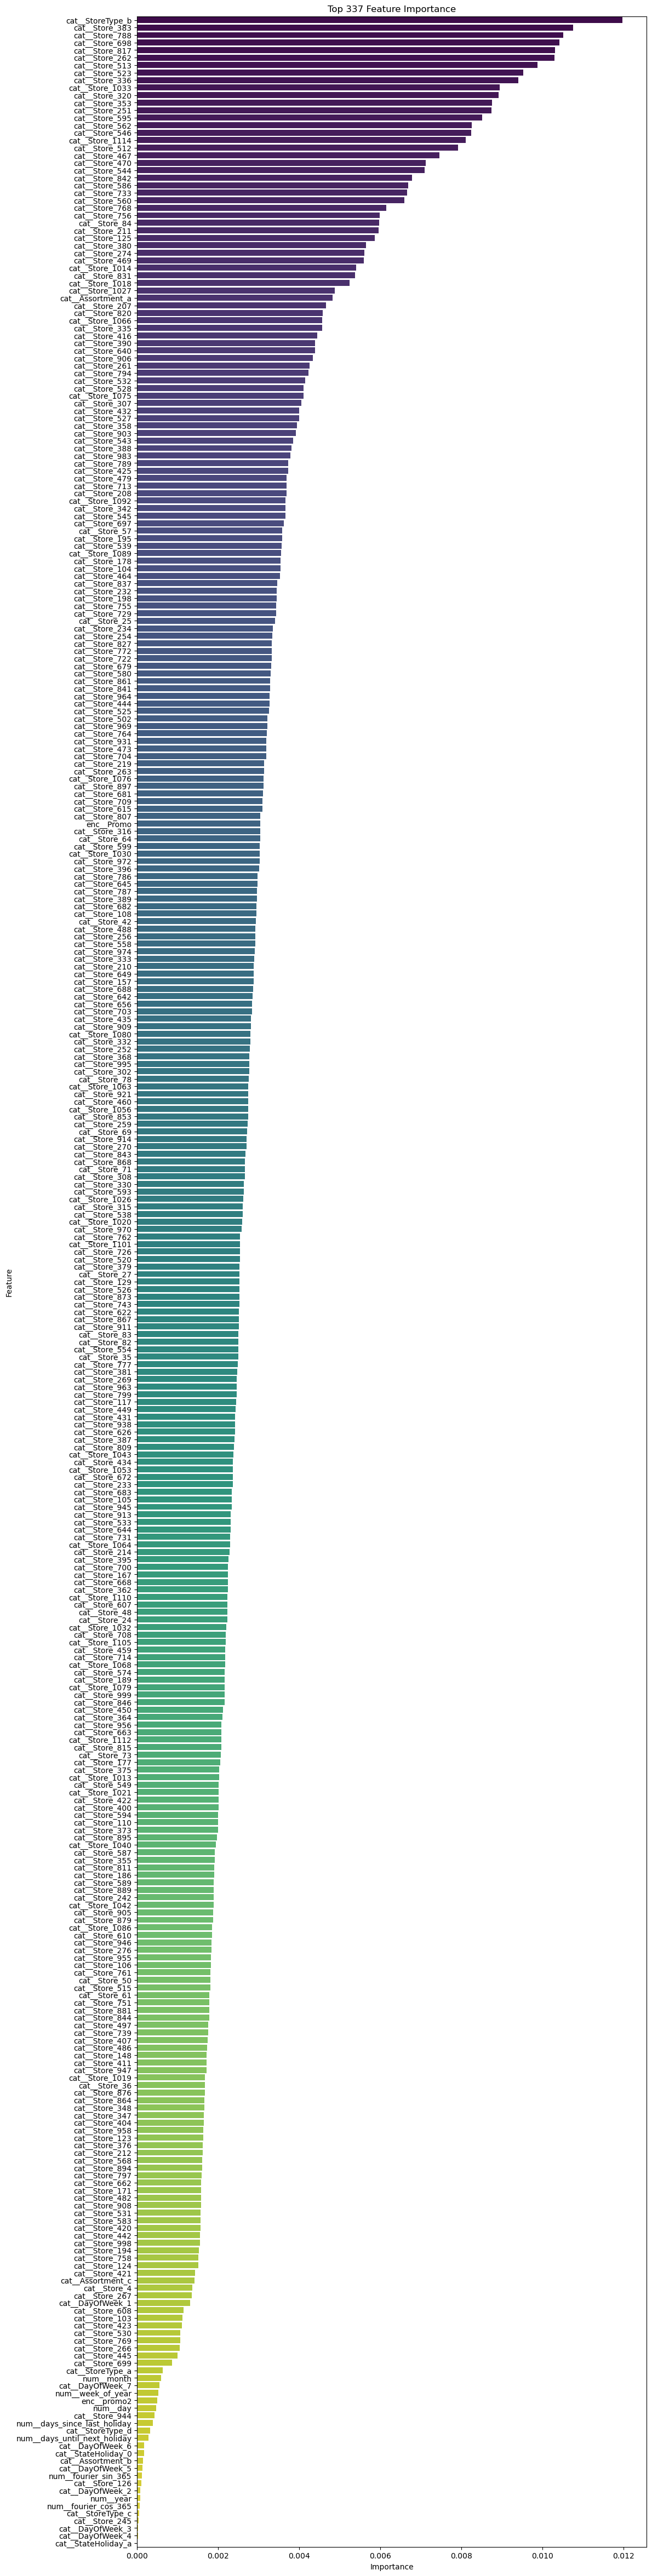

In [320]:
import matplotlib.pyplot as plt
import seaborn as sns


# DataFrame nach 'Importance' sortieren und Top-n Features zeigen
feature_importance_df_2 = feature_importance_df.sort_values(by='Importance', ascending=False)[:337]

# Größe der Abbildung
plt.figure(figsize=(12,60))

# Balkendiagramm
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')

# Titel und Beschriftungen 
plt.title('Top 337 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Rotieren der y-Achsenbeschriftungen
plt.yticks(rotation=0)

# Zeige Diagramm
plt.show()

## Hyperparameter Optimierung

### Optuna

Zum Tunen des XGBoost-Modells wird die Bibliothek Optuna genutzt. Die Funktion objective(trial) definiert die zu minimierende Zielfunktion. Optuna schlägt für jeden Versuch (Trial) verschiedene Hyperparameter vor, wie z. B. n_estimators, max_depth oder learning_rate, die dann in das XGBoost-Modell übernommen werden.

Mithilfe der Cross-Validation wird die Modellgüte durch Berechnung der RMSPE (Root Mean Squared Percentage Error) bewertet. Optuna optimiert die Hyperparameter, um diesen Fehlerwert zu minimieren.

Die Optuna-Studie umfasst dabei über 1000 Trials. Folgende Kombination der Hyperparameter stellt hat dabei den geringsten RMSPE-Wert ergeben: 

Beste Parameter: {'n_estimators': 900, 'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.2688555222102847, 'subsample': 0.8049082697078238, 'colsample_bytree': 0.9017085061339981, 'colsample_bylevel': 0.9016501277919797, 'gamma': 3.5191228580676372, 'reg_alpha': 0.4301285235544994, 'reg_lambda': 5.1451545907615355}

Bester Wert (RMSPE): 0.22514420173203087

Quelle: Optuna(a)

In [32]:
# Optuna-Objective-Funktion
def objective(trial):
    # Hyperparameter-Vorschläge durch Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 900),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0)
    }
    
    # XGBoost-Modell mit den vorgeschlagenen Parametern
    model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)

    # Pipeline mit dem Preprocessing und dem Modell
    pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
            ('model', model)   
    ])
    
    # Cross-Validation Score berechnen
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, n_jobs=-1)

    # Rückgabe durchschnittlicher RMSPE
    return -np.mean(cv_scores)

# Optuna-Studie erstellen und Optimierung starten
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())  # Pruner hinzugefügt
study.optimize(objective, n_trials=1000)

# Beste Ergebnisse anzeigen
print("Beste Parameter:", study.best_params)
print("Bester Wert (RMSPE):", study.best_value)

[I 2024-09-19 23:39:18,273] A new study created in memory with name: no-name-e354a574-ef94-4e8c-9d68-64cf2ce3ff8d
[I 2024-09-19 23:39:27,523] Trial 0 finished with value: 0.3449858854078026 and parameters: {'n_estimators': 183, 'max_depth': 8, 'min_child_weight': 9, 'learning_rate': 0.19905030354911354, 'subsample': 0.669326358389216, 'colsample_bytree': 0.6380515673753843, 'colsample_bylevel': 0.8023042626023913, 'gamma': 4.882532266457538, 'reg_alpha': 0.8664852089823155, 'reg_lambda': 8.064116430825486}. Best is trial 0 with value: 0.3449858854078026.
[I 2024-09-19 23:39:31,280] Trial 1 finished with value: 0.509184655648428 and parameters: {'n_estimators': 65, 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.04630744016152754, 'subsample': 0.6923022402603697, 'colsample_bytree': 0.7740796817062834, 'colsample_bylevel': 0.5379533550580375, 'gamma': 3.8374514916999525, 'reg_alpha': 0.5153494719347641, 'reg_lambda': 2.1797651001111817}. Best is trial 0 with value: 0.344985885

Beste Parameter: {'n_estimators': 900, 'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.2688555222102847, 'subsample': 0.8049082697078238, 'colsample_bytree': 0.9017085061339981, 'colsample_bylevel': 0.9016501277919797, 'gamma': 3.5191228580676372, 'reg_alpha': 0.4301285235544994, 'reg_lambda': 5.1451545907615355}
Bester Wert (RMSPE): 0.22514420173203087


### Study speichern

In [321]:
# Pfad zur Logdatei
log_file_path = '../data/study.txt'

# Leere Listen zur Speicherung der extrahierten Daten
trials_data = []

# RegEx zum Extrahieren der Daten
trial_pattern = r"Trial (\d+) finished with value: ([\d\.]+) and parameters: {(.*?)}"

# zeilenweise Log Datei lesen
with open(log_file_path, 'r') as f:
    for line in f:
        match = re.search(trial_pattern, line)
        if match:
            trial_number = int(match.group(1))
            value = float(match.group(2))
            parameters = match.group(3)
            
            # Dictionary der Parameter
            param_dict = {}
            param_pairs = parameters.split(", ")
            for pair in param_pairs:
                key, val = pair.split(": ")
                param_dict[key.strip("'")] = float(val)
            
            # Trial und den Wert zum Dictionary hinzufügen
            param_dict['trial_number'] = trial_number
            param_dict['value'] = value
            
            # Speicherung der Daten in der Liste
            trials_data.append(param_dict)

# Erstellung DataFrame 
df = pd.DataFrame(trials_data)

# Zeige DataFrame
df.head()

,n_estimators,max_depth,min_child_weight,learning_rate,subsample,colsample_bytree,colsample_bylevel,gamma,reg_alpha,reg_lambda,trial_number,value
0,183.0,8.0,9.0,0.199050,0.669326,0.638052,0.802304,4.882532,0.866485,8.064116,0,0.344986
1,65.0,3.0,4.0,0.046307,0.692302,0.774080,0.537953,3.837451,0.515349,2.179765,1,0.509185
2,570.0,7.0,1.0,0.099916,0.558821,0.581401,0.971238,0.997671,0.823823,5.840196,2,0.330888
3,856.0,6.0,7.0,0.103166,0.725121,0.909496,0.834733,3.825014,0.058231,1.824260,3,0.304007
4,885.0,9.0,1.0,0.024818,0.873442,0.532351,0.666999,1.457786,0.270874,2.648525,4,0.386812


In [322]:
# Erstellung neuer Optuna-Study
study = optuna.create_study(direction='minimize')

# Hinzufügen der Trials aus dem DataFrame zur Study
for index, row in df.iterrows():
    trial = optuna.trial.create_trial(
        params={
            'n_estimators': row['n_estimators'],
            'max_depth': row['max_depth'],
            'min_child_weight': row['min_child_weight'],
            'learning_rate': row['learning_rate'],
            'subsample': row['subsample'],
            'colsample_bytree': row['colsample_bytree'],
            'colsample_bylevel': row['colsample_bylevel'],
            'gamma': row['gamma'],
            'reg_alpha': row['reg_alpha'],
            'reg_lambda': row['reg_lambda']
        },
        distributions={
            'n_estimators': optuna.distributions.IntDistribution(50, 900),
            'max_depth': optuna.distributions.IntDistribution(3, 10),
            'min_child_weight': optuna.distributions.IntDistribution(1, 10),
            'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
            'subsample': optuna.distributions.FloatDistribution(0.5, 1.0),
            'colsample_bytree': optuna.distributions.FloatDistribution(0.5, 1.0),
            'colsample_bylevel': optuna.distributions.FloatDistribution(0.5, 1.0),
            'gamma': optuna.distributions.FloatDistribution(0, 5.0),
            'reg_alpha': optuna.distributions.FloatDistribution(0.0, 1.0),
            'reg_lambda': optuna.distributions.FloatDistribution(0.0, 10.0)
        },
        value=row['value'],  # Zielwert
        state=optuna.trial.TrialState.COMPLETE  # Alle Trials abgeschlossen
    )
    study.add_trial(trial)

[I 2024-09-23 15:15:13,511] A new study created in memory with name: no-name-31d85063-04c0-4b68-8012-5d09c53fb461


In [323]:
# Beste Ergebnisse anzeigen
print("Beste Parameter:", study.best_params)
print("Bester Wert (RMSPE):", study.best_value)

Beste Parameter: {'n_estimators': 900.0, 'max_depth': 10.0, 'min_child_weight': 8.0, 'learning_rate': 0.2688555222102847, 'subsample': 0.8049082697078238, 'colsample_bytree': 0.9017085061339981, 'colsample_bylevel': 0.9016501277919797, 'gamma': 3.5191228580676372, 'reg_alpha': 0.4301285235544994, 'reg_lambda': 5.1451545907615355}
Bester Wert (RMSPE): 0.22514420173203087


### Visualisierung

Quelle: Optuna(b)

#### Optimierungsverlauf

Der Optimierungsverlauf zeigt, dass der größte Optimierungssprung innerhalb der ersten 100 Trials sattfindet. Anschließend stagniert der Fortschritt mit einzelnen Ausnahmen im 600er und 900er Bereich.

In [324]:
# Optimierungsverlauf der Studie visualisieren
optuna.visualization.plot_optimization_history(study)

#### Parameteranalyse

Der optimierte XGBoost-Algorithmus zeigt eine Verbesserung des RMSPE bei höheren Lernraten zwischen 0.2 und 0.3. Zudem führte eine erhöhte Anzahl an n_estimators zu besseren Ergebnissen, wobei der RMSPE bei etwa 750 Estimators zu stagnieren beginnt. Die optimale max_depth liegt bei ca. 10, während kleinere Werte zu einer höheren Varianz im RMSPE führen, was auf eine instabile Modellleistung bei geringerer Tiefe hinweist. Insgesamt zeigen diese Einstellungen eine deutliche Verbesserung der Modellgenauigkeit.

In [325]:
# Parameteranalyse der Studie
optuna.visualization.plot_slice(study)

#### Hyperparameter Importance

Die Untersuchung der Hyperparameter Importances zeigt zeigt, dass die learning_rate und n_estimators die wichtigsten Hyperparameter sind, die das Modell maßgeblich beeinflussen. Eine Anpassung dieser beiden Parameter ist entscheidend für die Optimierung des Modells. Max_depth nimmt ebenfalls Einfluss, jedoch deutlich weniger. Die anderen Hyperparameter spielen nur eine untergeordnete Rolle in diesem Modell.

In [326]:
# Hyperparameter Importance visualisieren
optuna.visualization.plot_param_importances(study)

#### Hyperparameterkombinationen der wichtigsten drei Hyperparameter

Die Konturplots zeigen die Beziehung zwischen den Hyperparametern des XGBoost-Modells und der Zielmetrik RMSPE. Die besten Werte werden durch dunkle Bereiche (niedrige RMSPE) repräsentiert. Für die Hyperparameter n_estimators, learning_rate und max_depth zeigen die Diagramme, dass eine hohe Baumanzahl (über 600), eine Lernrate zwischen 0.2 und 0.3, sowie eine maximale Tiefe zwischen 7 und 10 zu besseren Ergebnissen führen. Die gewählten Parameter n_estimators = 900, learning_rate = ca. 0.2689 und max_depth = 10 befinden sich in einem Bereich niedriger RMSPE-Werte. 

In [327]:
# Extrahierung Parameter und Zielwerte aus Optuna-Studie
trials = study.trials_dataframe()

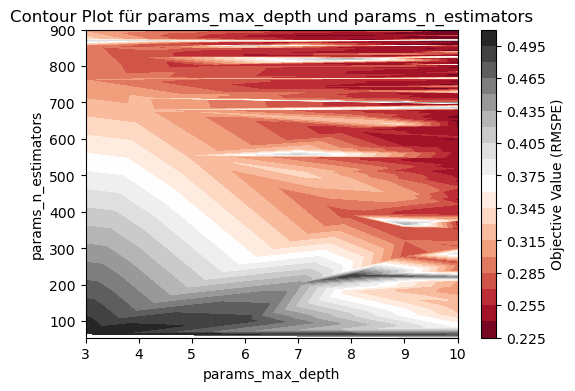

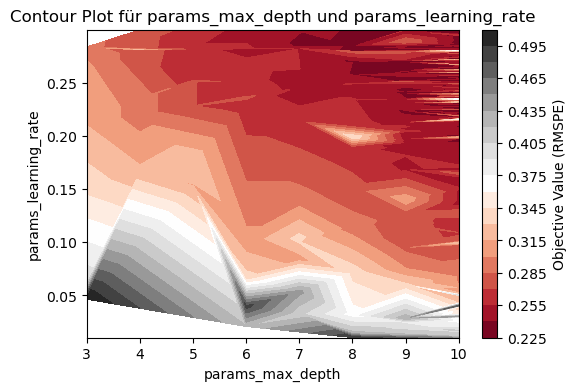

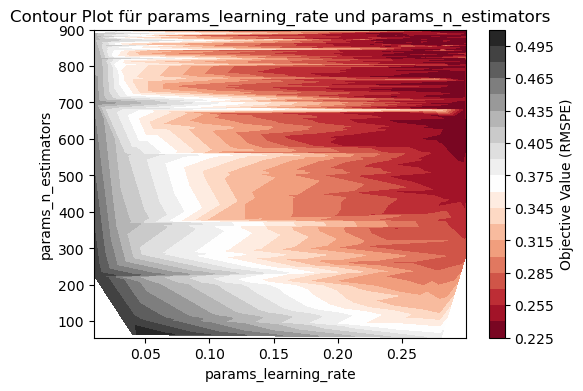

In [328]:
# Liste Parameterpaare
parameter_pairs = [
    ('params_max_depth', 'params_n_estimators'),
    ('params_max_depth', 'params_learning_rate'),
    ('params_learning_rate', 'params_n_estimators')
]

# Schleife durch jedes Parameterpaar und Erstellung Contour Plot
for param_x, param_y in parameter_pairs:
    
    df = trials[[param_x, param_y, 'value']].dropna()  

    # Werte für die Achsen und Zielmetrik extrahieren
    x = df[param_x].values
    y = df[param_y].values
    z = df['value'].values

    # Contour Plot
    plt.figure(figsize=(6, 4))
    plt.tricontourf(x, y, z, 20, cmap='RdGy')
    plt.colorbar(label='Objective Value (RMSPE)')
    
    # Achsenbeschriftungen und Titel 
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.title(f'Contour Plot für {param_x} und {param_y}')
    
    # Diagramm anzeigen
    plt.show()

## Finales Modell trainieren

### Beste Hyperparameter

Die Optuna Study konnte folgende XGBoost-Hyperparameter als die besten für das Rossmann-Problem identifizieren. Diese Parameter beinhalten unter anderem die Anzahl der Bäume (n_estimators), die maximale Tiefe der Bäume (max_depth), das Gewicht der Kindknoten (min_child_weight), die Lernrate (learning_rate), sowie die Subsampel- und Colsample-Werte, die bestimmen, wie viele Datenpunkte und Features in jedem Baum verwendet werden. Weitere Parameter wie gamma, reg_alpha, und reg_lambda regulieren die Komplexität des Modells und helfen, Overfitting zu verhindern.

In [329]:
# beste Parameter definieren
best_params = {
    'n_estimators': 900,
    'max_depth': 10,
    'min_child_weight': 8,
    'learning_rate': 0.2688555222102847,
    'subsample': 0.8049082697078238,
    'colsample_bytree': 0.9017085061339981,
    'colsample_bylevel':  0.9016501277919797,
    'gamma': 3.5191228580676372,
    'reg_alpha': 0.4301285235544994,
    'reg_lambda': 5.1451545907615355
}

### Initialisierung der Pipeline

Die XGBoost-Pipeline wird mit den besten Hyperparametern der Optunasuche initialisiert und anschließend das entsprechende Modell trainiert.

In [330]:
# finale Pipeline
pipeline_xgb_final = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
    ('model', xgboost.XGBRegressor(**best_params, random_state = 42))  # Schritt 3: Modellierung
])

### Training

In [331]:
# Training 
pipeline_xgb_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortm...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.2688555222102847, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=8, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=900, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

### Kreuzvalidierung

Die Kreuzvalidierungsergebnisse zeigen, dass sich die Modellgenauigkeit deutlich verbessert hat und der durchschnittliche RMSPE nur noch 0.22514420173203087 beträgt.

In [332]:
#Kreuzvalidierung
cv_scores_final = cross_val_score(pipeline_xgb_final, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)


In [333]:
# RMSPEs der einzelnen Folds
cv_scores_final

array([-0.27405909, -0.20175288, -0.18640017, -0.14414531, -0.31936357])

In [334]:
# durchschnittlicher RMSPE über alle Folds
mean_rmspe_final = np.mean(cv_scores_final)
print(mean_rmspe_final)

-0.22514420173203087


### Test

Auch das Testergebnis zeigt mit 0.16749093573181503 einen deutlich verbesserten RMSPE. Das finale Modell hat damit im Durchschnitt einen prozentualen Vorhersagefehler von etwa 16,75%. 

In [335]:
# Test-RMSPE 
y_pred_final = pipeline_xgb_final.predict(X_test)
test_rmspe_final = rmspe(y_test, y_pred_final)
print(test_rmspe_final)

0.16749093573181503


### Überprüfung Overfitting

Das Modell zeigt eine gute Generalisierung, da sowohl der RMSPE auf den Trainings- als auch auf den Testdaten niedrig ist. Der RMSPE auf den Trainingsdaten beträgt 19,23%, während der Wert auf den Testdaten bei 16,75% liegt, was darauf hinweist, dass das Modell nicht overfitted ist und neue Daten gut vorhersagen kann. Die Learning Curve zeigt, dass der RMSPE mit zunehmender Trainingsdatengröße sowohl auf den Trainings- als auch auf den Validierungsdaten sinkt. Die Schattierung um die Cross-Validation-Linie deutet jedoch auf eine gewisse Variabilität in den verschiedenen Datensplits hin, was darauf schließen lässt, dass die Leistung des Modells über verschiedene Datensätze hinweg leicht schwanken kann. Insgesamt liefert das Modell stabile und akzeptable Vorhersagen.

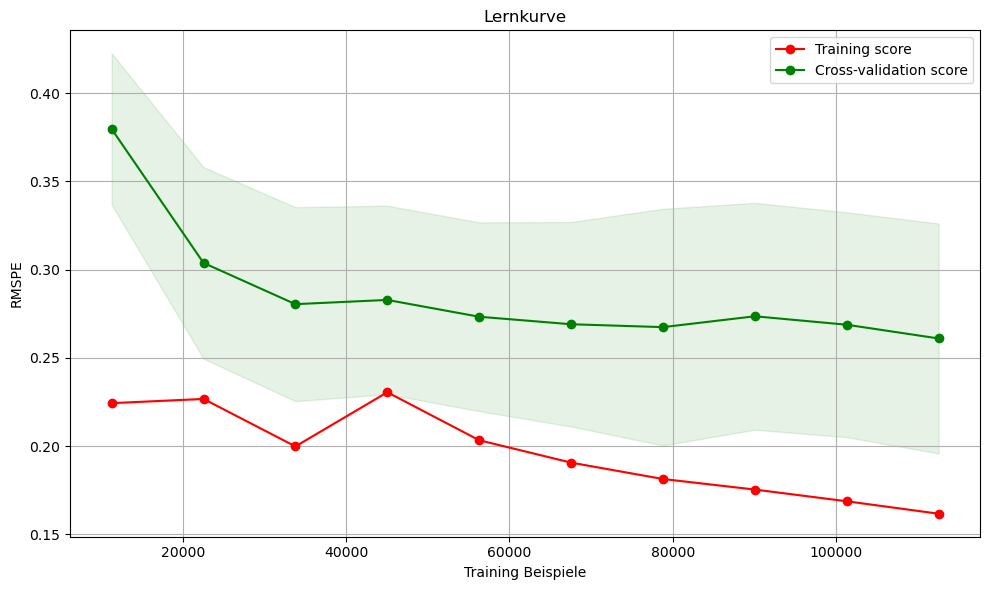

In [285]:
# train_sizes: Anteile der Trainingsdaten (10% bis 100%)
# train_scores/test_scores: RMSPE-Scores auf Train/Test-Sätzen
train_sizes, train_scores, test_scores = learning_curve(pipeline_xgb_final, X_train, y_train, cv=tscv, scoring=rmspe_scorer, train_sizes=np.linspace(0.1, 1.0, 10))

# Berechnung mittlere und Standardabweichungen der Scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training Beispiele")
plt.ylabel("RMSPE")
plt.title("Lernkurve")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [336]:
# Vorhersage auf Trainingsdaten
y_train_pred = pipeline_xgb_final.predict(X_train)

# Vorhersage auf Testdaten
y_test_pred = pipeline_xgb_final.predict(X_test)

# Berechnung RMSPE auf den Trainings- und Testdaten
train_rmspe = rmspe(y_train, y_train_pred)
test_rmspe = rmspe(y_test, y_test_pred)

print(f'Training RMSPE: {train_rmspe}')
print(f'Test RMSPE: {test_rmspe}')

Training RMSPE: 0.19228065542947473
Test RMSPE: 0.16749093573181503


## RMSPE-Analyse

In der Analyse ist ersichtlich, dass das Modell die Haupttrends und saisonalen Muster der Verkaufszahlen gut erfasst, insbesondere die Spitzenwerte. Dennoch zeigen die Diagramme, dass es in den niedrigeren Bereichen tendenziell zu einer Überbewertung kommt, was zu einer leichten Überschätzung der Verkaufszahlen führt. Insgesamt funktionieren die Vorhersagen für die höheren Verkaufszahlen und stärkeren Schwankungen besser, während bei den niedrigeren Werten die Vorhersagegenauigkeit abnimmt. Somit hat das Modell weiterhin Potenzial zur Verbesserung.

Quelle: Brownlee(2021)

In [337]:
# Konvertierung der 'Date'-Spalte in Datetime-Format
X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce')  # Konvertiere in Datetime, Fehler werden als NaT behandelt

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_37392/763283604.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



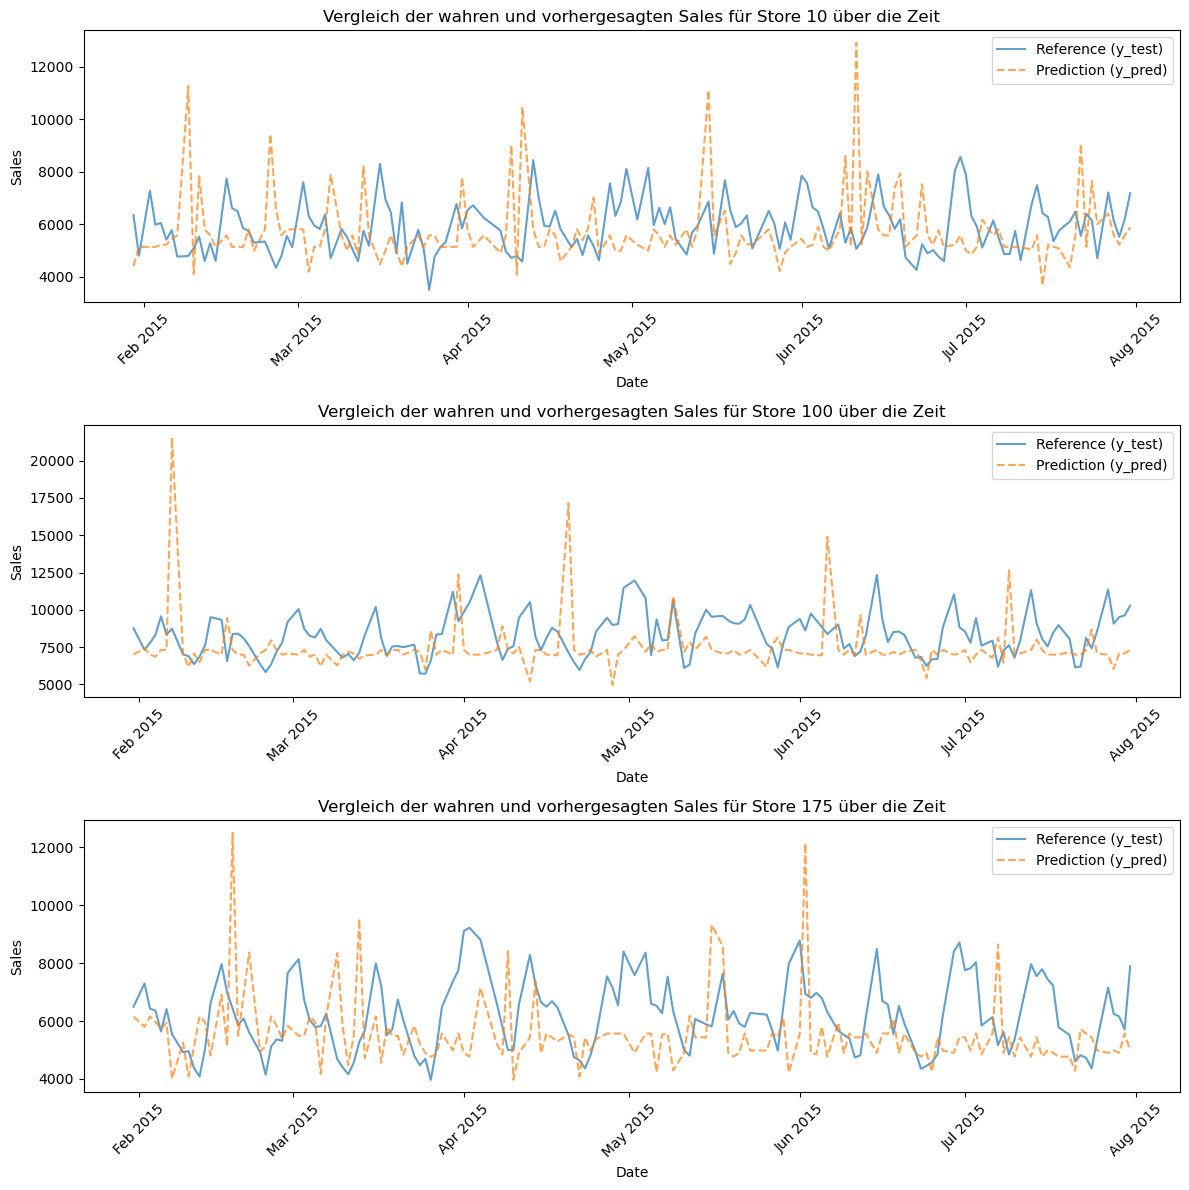

In [349]:
# Liste Stores
store_list = [10, 100, 175]  # Beispiel: Stores 1, 2, 3

# Anzahl Subplots festlegen
num_stores = len(store_list)
fig, axes = plt.subplots(num_stores, 1, figsize=(12, 4 * num_stores))

if num_stores == 1:
    axes = [axes]  

# Schleife über Stores
for i, store in enumerate(store_list):
    # Filtern der Testdaten für aktuellen Store
    store_test_data = X_test[X_test['Store'] == store]
    store_y_test = y_test[store_test_data.index]
    
    # Indizes herausfinden
    store_indices = store_test_data.index
    
    # Vorhersagen für diese Indizes extrahieren
    store_y_pred = y_pred[store_indices - X_test.index.min()]
    
    # Sortieren nach Datum
    store_test_data = store_test_data.sort_values('Date')
    store_y_test = store_y_test[store_test_data.index]
    store_y_pred = store_y_pred[np.argsort(store_test_data['Date'].values)]
    
    # Plotten für aktuellen Store
    axes[i].plot(store_test_data['Date'], store_y_test, label='Reference (y_test)', linestyle='-', marker='', alpha=0.7)
    axes[i].plot(store_test_data['Date'], store_y_pred, label='Prediction (y_pred)', linestyle='--', marker='', alpha=0.7)
    
    # X-Achsen Formatierung: Nur einmal pro Monat anzeigen
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Monatliche Ticks
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Nur Monat und Jahr anzeigen
    
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].set_title(f'Vergleich der wahren und vorhergesagten Sales für Store {store} über die Zeit')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)  # X-Achse drehen, um die Daten lesbar zu machen

plt.tight_layout()
plt.show()

### RMSPE-Analyse am Beispiel von Store 10

Im ersten Diagramm werden die kumulierten tatsächlichen und vorhergesagten Verkaufszahlen für Store 10 dargestellt. Die beiden Linien verlaufen über den betrachteten Zeitraum hinweg eng beieinander, was auf eine relativ hohe Vorhersagegenauigkeit des Modells hinweist. Zwar scheint das Modell generell dazu zu tendieren zu viele Sales vorherzusagen, jedoch zeigt der gleichmäßige Anstieg, dass das Modell den Verkaufsverlauf insgesamt gut erfasst und robust vorhersagt.

Das Streudiagramm zeigt die Übereinstimmung zwischen den tatsächlichen und den vorhergesagten Verkaufszahlen. Die meisten Datenpunkte liegen nahe der idealen Linie, was auf eine starke Vorhersagegenauigkeit hinweist. Einige Abweichungen sind bei höheren Verkaufszahlen zu erkennen, was auf gelegentliche Unterschätzungen oder Überschätzungen durch das Modell hindeutet. Trotzdem zeigt das Modell insgesamt eine gute Generalisierung und eine hohe Vorhersagegenauigkeit.

In [340]:
# data_vis definieren
data_vis = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

In [341]:
# Datensatz sortieren
data_vis = data_vis.sort_values('Date')

# geschlossene und Tage ohne Sales entfernen
data_vis = data_vis[data_vis ['Open']!=0]
data_vis = data_vis[data_vis ['Sales']>0]

In [350]:
# Definition Store
store_id = 10  
store_data = data_vis[data_vis['Store'] == store_id]

# Aufteilung der Daten für Store in Features (X) und Zielvariable (y)
X_store = store_data.drop('Sales', axis=1)  # Merkmale ohne Sales
y_store = store_data['Sales']  # Tatsächliche Verkaufszahlen

# Vorhersagen für den Store
y_store_pred = pipeline_xgb.predict(X_store)

# Erstellung Dataframe
results = pd.DataFrame({
    'Date': store_data['Date'],
    'Actual Sales': y_store,
    'Predicted Sales': y_store_pred
})

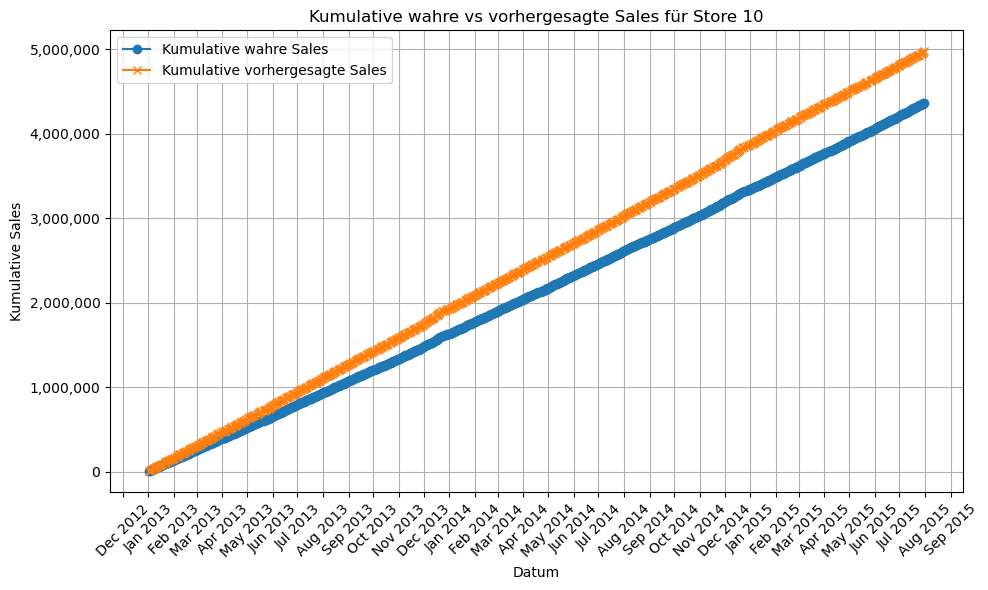

In [351]:
# Sicherstellen, dass die 'Date'-Spalte im richtigen Datetime-Format ist
results['Date'] = pd.to_datetime(results['Date'], errors='coerce')

# Kumulierte Verkaufszahlen berechnen
results['Cumulative Actual Sales'] = results['Actual Sales'].cumsum()
results['Cumulative Predicted Sales'] = results['Predicted Sales'].cumsum()

# Plot kumulierter Verkaufszahlen
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Cumulative Actual Sales'], label='Kumulative wahre Sales', marker='o')
plt.plot(results['Date'], results['Cumulative Predicted Sales'], label='Kumulative vorhergesagte Sales', marker='x')

# X-Achse: Monate anzeigen
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Nur Monate anzeigen
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format: Monat und Jahr (z.B. Jan 2015)

# Y-Achse: Ganze Zahlen
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))  

# Achsenbeschriftungen und Titel
plt.xlabel('Datum')
plt.ylabel('Kumulative Sales')
plt.title(f'Kumulative wahre vs vorhergesagte Sales für Store {store_id}')
plt.legend()

# Drehung der X-Achsen-Beschriftungen für bessere Lesbarkeit
plt.xticks(rotation=45)

# Rasterlinien
plt.grid(True)

# Layout-Anpassung
plt.tight_layout()

# Plot anzeigen
plt.show()

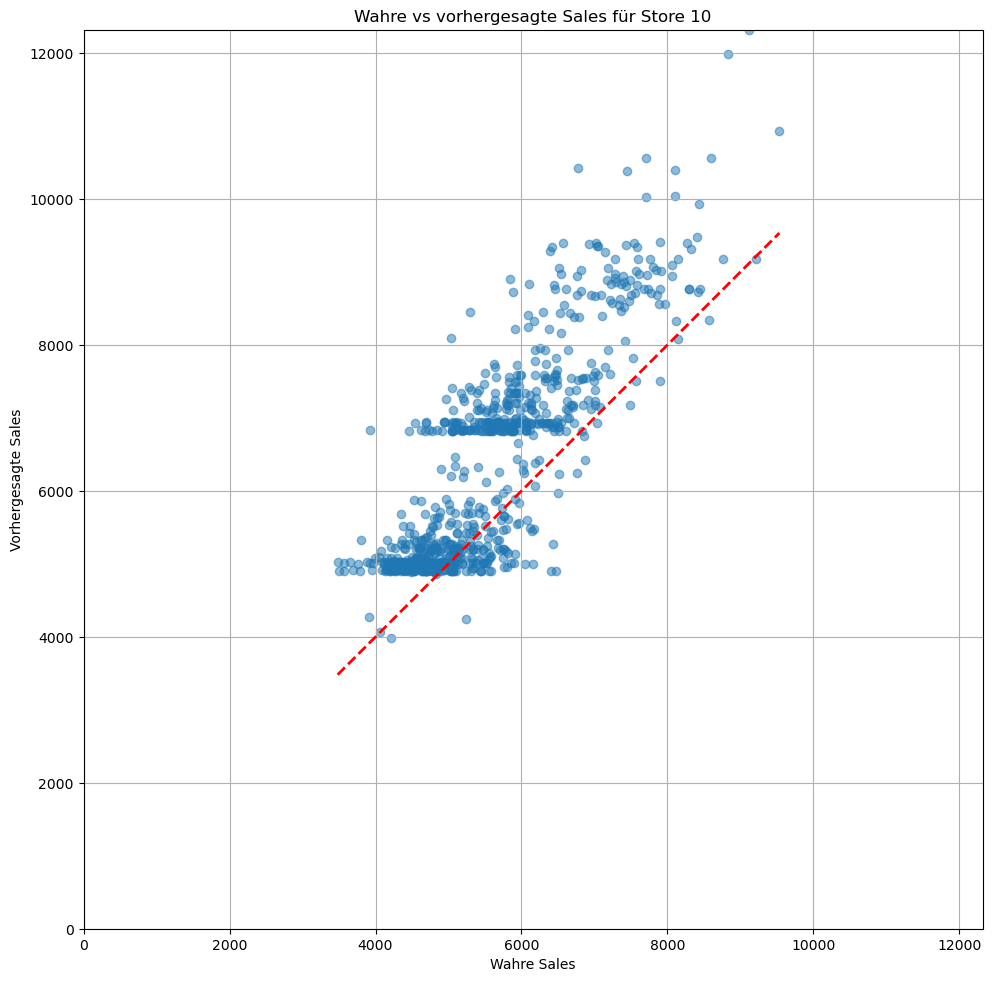

In [352]:
# Plot
plt.figure(figsize=(10, 10))
plt.scatter(y_store, y_store_pred, alpha=0.5)

# Plot der Linie für perfekte Übereinstimmung
plt.plot([y_store.min(), y_store.max()], [y_store.min(), y_store.max()], 'r--', lw=2)

# Achsenbeschriftungen und Titel
plt.xlabel('Wahre Sales')
plt.ylabel('Vorhergesagte Sales')
plt.title(f'Wahre vs vorhergesagte Sales für Store {store_id}')

# Startwert der Achsen bei 0 setzen und gleiche Achsenlimits für X und Y
plt.xlim([0, max(y_store.max(), y_store_pred.max())])
plt.ylim([0, max(y_store.max(), y_store_pred.max())])

# Seitenverhältnis der Achsen gleichsetzen
plt.gca().set_aspect('equal', adjustable='box')

# Gitter anzeigen
plt.grid(True)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(y_store, y_store_pred, alpha=0.5)

# Plot der Linie für perfekte Übereinstimmung
plt.plot([y_store.min(), y_store.max()], [y_store.min(), y_store.max()], 'r--', lw=2)

# Achsenbeschriftungen und Titel
plt.xlabel('Wahre Sales')
plt.ylabel('Vorhergesagte Sales')
plt.title(f'Wahre vs vorhergesagte Sales für Store {store_id}')

# Startwert der Achsen bei 0 setzen und gleiche Achsenlimits für X und Y
plt.xlim([0, max(y_store.max(), y_store_pred.max())])
plt.ylim([0, max(y_store.max(), y_store_pred.max())])

# Seitenverhältnis der Achsen gleichsetzen
plt.gca().set_aspect('equal', adjustable='box')

# Gitter anzeigen
plt.grid(True)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

## Alternative Features

### Lag-Features

Das Hinzufügen der Lag-Features zeigt eine deutliche Verschlechterung des RMSPE, vor allem in der Hinsicht, dass ein großer Teil der Lag-Features auf selbst vorhergesagten Sales besteht. Dementsprechend kommen die Lag-Features als Vorhersagemerkmal, trotz der positiven Einschätzung der Features während der EDA, nicht in Frage.

In [294]:
# numerische Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday', 'lag_1', 'lag_7'] # lag_1, lag_7 entfernt

# encodierte Features
already_encoded_features = ['Promo', 'promo2']

# kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

In [295]:
# preprocessor
preprocessor_lag = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  
        ('enc', 'passthrough', already_encoded_features), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode) 
    ])

In [296]:
# pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_lag),
    ('model', xgboost.XGBRegressor(random_state = 42))
])

In [297]:
def rmspe_lag(y_true, y_pred):
    # Konvertierung y_pred in Pandas Series, um gleiche Indexierung zu ermöglichen
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Nur Fälle berücksichtigen, bei denen y_true nicht 0 ist
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

In [298]:
# iterative Vorhersagefunktion (mit Berücksichtigung von Lag- und zusätzlichen Features)
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    # Training des Modells
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_fold_train[-7:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    # Iteriere über die Zeilen von X_fold_val
    for index, row in X_fold_val.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan  # Lag-7 ist 7 Tage zurück
            
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
        
        # Wandeln der Zeile in DataFrame, um Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Preprocessing 
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update letzte bekannte Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

# Durchführung Kreuzvalidierung auf Trainingsdaten
rmspe_scores = []  # Liste RMSPE-Scores

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Train- und Testdaten für diesen Fold
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    # Preprocessing auf Train- und Testdaten anwenden
    X_fold_train_preprocessed = pipeline.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = pipeline.named_steps['preprocessor'].transform(X_fold_test)
    
    # Iterative Vorhersage über die Testperiode
    y_pred = iterative_forecast(pipeline, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    
    # RMSPE berechnen und speichern
    rmspe_score = rmspe_lag(y_fold_test, y_pred)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

# Gesamtergebnisse
print(f"Durchschnittliche RMSPE über alle Folds: {np.mean(rmspe_scores)}")

Fold 1
RMSPE for Fold 1: 1.1959192034575377
Fold 2
RMSPE for Fold 2: 1.4360647363997099
Fold 3
RMSPE for Fold 3: 1.7292506380802504
Fold 4
RMSPE for Fold 4: 1.3840823686229236
Fold 5
RMSPE for Fold 5: 1.5524105332676146
Durchschnittliche RMSPE über alle Folds: 1.4595454959656073


## Quellen

Brownlee. (2020, April 27). Feature importance and feature selection with XGBoost in Python. Machine Learning Mastery. https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

Brownlee. (2021, March 19). XGBoost for time series forecasting. Machine Learning Mastery. https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

Optuna. (a). Code examples. Optuna. Retrieved September 23, 2024, from https://optuna.org/#code_examples

Optuna. (b). Visualization reference. Optuna documentation. Retrieved September 23, 2024, from https://optuna.readthedocs.io/en/stable/reference/visualization/index.html

Scikit-learn developers. (a). sklearn.pipeline.Pipeline. Scikit-learn. Retrieved September 23, 2024, from https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Scikit-learn developers. (b). sklearn.model_selection.cross_val_score. Scikit-learn. Retrieved September 23, 2024, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

XGBoost developers. (a). Scikit-learn API: Distributed training. XGBoost documentation. Retrieved September 23, 2024, from https://xgboost.readthedocs.io/en/stable/python/examples/sklearn_parallel.html#sphx-glr-python-examples-sklearn-parallel-py

XGBoost developers. (b). xgboost.XGBRFRegressor. XGBoost documentation. Retrieved September 23, 2024, from https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRFRegressor